In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import xgboost as xgb
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

# About Notebook

## Mindmap(Only part of my notes)

### Missing values treatment

![fydcc8](https://testksj.oss-cn-beijing.aliyuncs.com/uPic/fydcc8.png)

### Outliers treatment
![TprssW](https://testksj.oss-cn-beijing.aliyuncs.com/uPic/TprssW.png)

## Summary from EDA:


- The bike rental count is generally lower on weekends, which may be due to less demand for transportation during leisure time. There are also fewer outliers during this time, indicating a more consistent demand. 
- The spring season has a relatively lower bike rental count, which could be attributed to unpredictable weather or other seasonal factors. The average bike demand during the winter season is slightly lower than the summer and fall seasons, which may be due to the inclement weather and holidays causing people to travel less. 
- The median value of bike rentals by hour of the day is relatively high during the hours of 7AM-8AM and 5PM-6PM, which can be attributed to regular commuters for school and work. 
- The pattern of registered bike rentals by hour of the day is similar to that of all bike rentals, but most of the outliers in the count plot are from non-registered users, which could be from tourists or occasional riders. The peak rental count around 7AM-8AM and 5PM-6PM is primarily from registered users, as people with regular commute times tend to be registered users. This indicates a strong correlation between registered users and regular commuter patterns.

weather -
1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fo

- Horrible weather like weather 4 mainly happened in Spring season which supports our previous assumption that weather conditions play a major role in leading less bike rental demand during spring season.




- It is observed that many people, regardless of their registration status, tend to rent bicycles between 10AM and 4PM. This trend is likely due to the fact that people are more likely to use bicycles for leisure activities during this time of the day. 

- Furthermore, it is also found that most un-registered users tend to rent bicycles around 10am-3pm on weekends. This could be because casual users may use other forms of transportation to go to work/school during the weekdays and only rent bicycles during weekends for recreational activities. 

- On weekdays, the peak rental count around 7AM-8AM and 5PM-6PM is primarily contributed by registered users. As previously mentioned, this can be attributed to regular school and office commuters who rely on bicycles as their primary mode of transportation during these times.


- The count pattern between casual and registered users are really different so it's better to use two models to predict them seperately and then sum up the prediction.

# About Dataset

#### **Data Fields**

* datetime - hourly date + timestamp  
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather - 
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals (Dependent Variable)

In [2]:
# Load dataset
train = pd.read_csv('/kaggle/input/bike-sharing-demand/train.csv')
test = pd.read_csv('/kaggle/input/bike-sharing-demand/test.csv')

In [3]:
train.shape

(10886, 12)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
# test dataset doesn't have 'casual', 'registered' columns and target column 'count'
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


In [6]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [7]:
# According to the data field explaination, we can seperate columns into: (not the real Dtype)

# numerical columns
numeric_cols = ['temp', 'atemp','humidity', 'windspeed']

# categorical columns
category_cols = ['season', 'holiday', 'weather']

# time series column 
['datetime']

# target
target = 'count'

# casual, registered columns will be dropped

# sanity check
#assert len(category_cols) + len(numeric_cols) + 1 == train.shape[1]

# Parse datetime

In [8]:
def parse_datetime(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    # df['time'] = df.datetime.dt.strftime('%H:%M:%S')
    # 
    df['week'] = df['datetime'].dt.isocalendar().week
    df['weekday'] = df['datetime'].dt.dayofweek
parse_datetime(train)
parse_datetime(test)
#train.drop(['datetime', 'casual', 'registered'], axis=1, inplace=True)
#test.drop(['datetime'], axis=1, inplace=True)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,week,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,52,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,52,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,52,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,52,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,52,5


# Missing values

In [9]:
def missing (df):
    """
    calculate % missing value for each column
    """
    missing_number = df.isnull().sum().sort_values(ascending=False)                              
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)         
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['missNum', 'missPercent'])   
    return missing_values

missing(train)

,missNum,missPercent
datetime,0,0.0
season,0,0.0
week,0,0.0
hour,0,0.0
day,0,0.0
month,0,0.0
year,0,0.0
count,0,0.0
registered,0,0.0
casual,0,0.0


## Detect special missing value like 0

The absence of a missing value only means that there is no None or Nan in the dataset, and does not exclude the possibility that other values may be used to represent missing values such as 0,-9999, "None", " ". From the describe table below, we noticed that 'humidity' and 'windspeed' have value 0

In [10]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,week,weekday
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,2011.501929,6.521495,9.992559,11.541613,25.917784,3.013963
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.500019,3.444373,5.476608,6.915838,15.017269,2.004585
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,2011.000000,4.000000,5.000000,6.000000,14.000000,1.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,2012.000000,7.000000,10.000000,12.000000,26.000000,3.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,2012.000000,10.000000,15.000000,18.000000,40.000000,5.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,2012.000000,12.000000,19.000000,23.000000,52.000000,6.000000


In [11]:
for feature in train[category_cols]:
        print(f'{feature}: {train[feature].unique()}')

season: [1 2 3 4]
holiday: [0 1]
weather: [1 2 3 4]


Season, Holiday and weather don't have missing values

In [12]:
# check if space " " is used to represent missing value
def find_index(data_col, val):
    """
    Query the index of the first occurrence of a value in a column, or -1 if none
    """
    val_list = [val]
    if data_col.isin(val_list).sum() == 0:
        index = -1
    else:
        index = data_col.isin(val_list).idxmax()
    return index

for col in numeric_cols:
    print(find_index(train[col], " "))
    
# None

-1
-1
-1
-1


In [13]:
# check if space 0 is used to represent missing value
def find_index(data_col, val):
    """
    Query the index of the first occurrence of a value in a column, or -1 if none
    """
    val_list = [val]
    if data_col.isin(val_list).sum() == 0:
        index = -1
    else:
        index = data_col.isin(val_list).idxmax()
    return index

is_0 = []
for col in numeric_cols:
    is_0.append(find_index(train[col], 0))

numeric_cols = ['temp', 'atemp','humidity', 'windspeed']
missing_check_0 = pd.DataFrame({'cols': numeric_cols, 'is_0': is_0})
missing_check_0


,cols,is_0
0,temp,-1
1,atemp,-1
2,humidity,1091
3,windspeed,0


In [14]:
print(train['windspeed'].unique())
print(train['humidity'].unique())

[ 0.      6.0032 16.9979 19.0012 19.9995 12.998  15.0013  8.9981 11.0014
 22.0028 30.0026 23.9994 27.9993 26.0027  7.0015 32.9975 36.9974 31.0009
 35.0008 39.0007 43.9989 40.9973 51.9987 46.0022 50.0021 43.0006 56.9969
 47.9988]
[ 81  80  75  86  76  77  72  82  88  87  94 100  71  66  57  46  42  39
  44  47  50  43  40  35  30  32  64  69  55  59  63  68  74  51  56  52
  49  48  37  33  28  38  36  93  29  53  34  54  41  45  92  62  58  61
  60  65  70  27  25  26  31  73  21  24  23  22  19  15  67  10   8  12
  14  13  17  16  18  20  85   0  83  84  78  79  89  97  90  96  91]


We successfully found out that humidity and windspeed columns has 0 which not make sense in real life. So we should consider 0 as missing values representation.

In [15]:
def zero_missing_percent(data, miss_col):
    miss_num = train[train[miss_col]==0].shape[0]
    miss_pct = round(miss_num/train.shape[0],4)
    print(f"There are {miss_num} missing values in {miss_col} column so missing percentage is {miss_pct}")

zero_missing_percent(train, 'windspeed')
zero_missing_percent(train, 'humidity')

There are 1313 missing values in windspeed column so missing percentage is 0.1206
There are 22 missing values in humidity column so missing percentage is 0.002


There are many ways to impute missing values. Let's use random forest tree model to predict missing values in windspeed column.

In [16]:
from sklearn.ensemble import RandomForestClassifier
def wind_0_fill(df):
    wind_0 = df[df['windspeed']==0]
    wind_not0 = df[df['windspeed']!=0]
    y_label = wind_not0['windspeed']
    rfc = RandomForestClassifier(n_estimators=1000,max_depth=10,random_state=0)
    windcolunms = ['season', 'weather', 'temp', 'atemp', 'humidity', 'hour', 'month']
    rfc.fit(wind_not0[windcolunms], y_label.astype('int'))
    pred_y = rfc.predict(wind_0[windcolunms])
    wind_0['windspeed'] = pred_y
    df_rfw = wind_not0.append(wind_0)
    df_rfw.reset_index(inplace=True)
    return df_rfw
train = wind_0_fill(train)
test = wind_0_fill(test)

# outliers

In [17]:
train['count'].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

In [18]:
def detect_outliers_3sigma(data):
    # calculate the mean and standard deviation of the data
    mean = np.mean(data)
    std = np.std(data)
    
    # define the cutoff for what constitutes an outlier
    cutoff = 3 * std
    
    # boxplot
    sn.boxplot(data, orient="v")
    plt.show()
    
    # print lower, upper boundry
    lower, upper = mean-3*std, mean+3*std
    print(f"The lower/upper boundary is {lower}/{upper}")
    
    # identify outliers
    outliers = [x for x in data if np.abs(x - mean) > cutoff]
    print(f"There are {len(outliers)} outliers based on 3-sigma rule")
    #return outliers


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


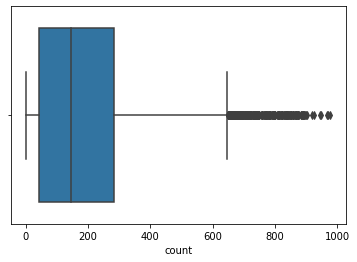

The lower/upper boundary is -351.8342688102495/734.9825326353459
There are 147 outliers based on 3-sigma rule


In [19]:
detect_outliers_3sigma(train['count'])

In [20]:
def delete_outliers(data, df):
    original_shape = df.shape
    mean = np.mean(data)
    std = np.std(data)
    outliers=np.abs(data-mean) > (3*std)
    outliers_num = len(train[outliers])
    df.drop(index=data[outliers].index, inplace=True)
    print("Have already deleted",outliers_num,"outliers")
    print ("Shape Before Delete Ouliers: ",original_shape)
    print ("Shape After Delete Ouliers: ",df.shape)

In [21]:
delete_outliers(train['count'], train)

Have already deleted 147 outliers
Shape Before Delete Ouliers:  (10886, 19)
Shape After Delete Ouliers:  (10739, 19)


# Correlation heatmap

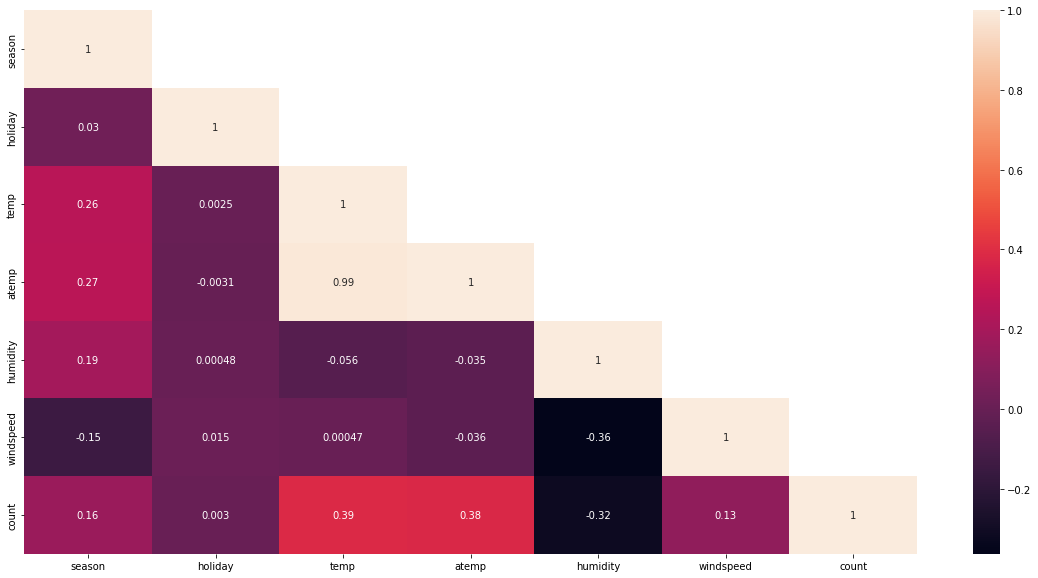

In [22]:
def correlation_heatmap(corr):
    mask = np.array(corr)
    mask[np.tril_indices_from(mask)] = False
    fig,ax= plt.subplots()
    fig.set_size_inches(20,10)
    sn.heatmap(corr, annot=True, mask=mask)

corr = train[['season', 'holiday','temp', 'atemp','humidity', 'windspeed', 'count']].corr()
correlation_heatmap(corr)

The variable 'atemp' has a strong correlation with the variable 'temp'. Having both variables in the model would cause multicollinearity, so one of them should be removed during model training.

# Special Days

In [23]:
def get_day(day_start):
   day_end = day_start + pd.offsets.DateOffset(hours=23)
   return pd.date_range(day_start, day_end, freq="H")

In [24]:
# set datetime as index
dt = pd.DatetimeIndex(train['datetime'])
train.set_index(dt, inplace=True)
dtt = pd.DatetimeIndex(test['datetime'])
test.set_index(dtt, inplace=True)
def get_day(day_start):
    day_end = day_start + pd.offsets.DateOffset(hours=23)
    return pd.date_range(day_start, day_end, freq="H")


# tax day
train.loc[get_day(pd.datetime(2011, 4, 15)), "workingday"] = 1
train.loc[get_day(pd.datetime(2012, 4, 16)), "workingday"] = 1
# thanksgiving friday
test.loc[get_day(pd.datetime(2011, 11, 25)), "workingday"] = 0
test.loc[get_day(pd.datetime(2012, 11, 23)), "workingday"] = 0
# tax day
train.loc[get_day(pd.datetime(2011, 4, 15)), "holiday"] = 0
train.loc[get_day(pd.datetime(2012, 4, 16)), "holiday"] = 0
# thanksgiving friday
test.loc[get_day(pd.datetime(2011, 11, 25)), "holiday"] = 1
test.loc[get_day(pd.datetime(2012, 11, 23)), "holiday"] = 1

# storms
test.loc[get_day(pd.datetime(2012, 5, 21)), "holiday"] = 1
# tornado
train.loc[get_day(pd.datetime(2012, 6, 1)), "holiday"] = 1


# Chrismas
test.loc[get_day(pd.datetime(2011, 12, 24)), "workingday"] = 0
test.loc[get_day(pd.datetime(2011, 12, 31)), "workingday"] = 0
test.loc[get_day(pd.datetime(2012, 12, 26)), "workingday"] = 0
test.loc[get_day(pd.datetime(2012, 12, 31)), "workingday"] = 0

test.loc[get_day(pd.datetime(2011, 12, 24)), "holiday"] = 1
test.loc[get_day(pd.datetime(2011, 12, 31)), "holiday"] = 1
test.loc[get_day(pd.datetime(2012, 12, 31)), "holiday"] = 1


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWar

In [25]:
#train.to_csv('/kaggle/working/train_new.csv',index=False)
#test.to_csv('/kaggle/working/test_new.csv',index=False)

# Visualization

[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Casual Count'),
 Text(0.5, 1.0, 'Box Plot On Casual Count Across Hour Of The Day')]

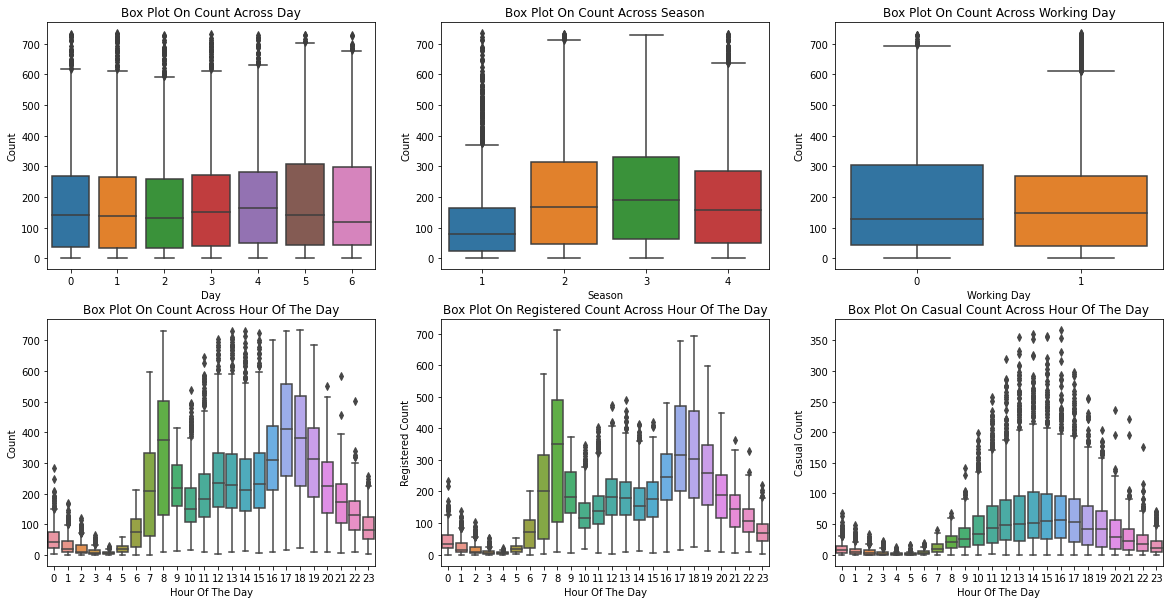

In [26]:
# ref: https://www.kaggle.com/code/viveksrinivasan/eda-ensemble-model-top-10-percentile#About-Dataset
fig, axes = plt.subplots(nrows=2,ncols=3)
fig.set_size_inches(20, 10)

sn.boxplot(data=train,y="count",x='weekday',orient="v",ax=axes[0][0])
sn.boxplot(data=train,y="count",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=train,y="count",x="workingday",orient="v",ax=axes[0][2])
sn.boxplot(data=train,y="count",x="hour",orient="v",ax=axes[1][0])
sn.boxplot(data=train,y="registered",x="hour",orient="v",ax=axes[1][1])
sn.boxplot(data=train,y="casual",x="hour",orient="v",ax=axes[1][2])

axes[0][0].set(xlabel='Day',ylabel='Count',title="Box Plot On Count Across Day")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[0][2].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Hour Of The Day', ylabel='Registered Count',title="Box Plot On Registered Count Across Hour Of The Day")
axes[1][2].set(xlabel='Hour Of The Day', ylabel='Casual Count',title="Box Plot On Casual Count Across Hour Of The Day")

- The bike rental count is generally lower on weekends, which may be due to less demand for transportation during leisure time. There are also fewer outliers during this time, indicating a more consistent demand. 
- The spring season has a relatively lower bike rental count, which could be attributed to unpredictable weather or other seasonal factors. The average bike demand during the winter season is slightly lower than the summer and fall seasons, which may be due to the inclement weather and holidays causing people to travel less. 
- The median value of bike rentals by hour of the day is relatively high during the hours of 7AM-8AM and 5PM-6PM, which can be attributed to regular commuters for school and work. 
- The pattern of registered bike rentals by hour of the day is similar to that of all bike rentals, but most of the outliers in the count plot are from non-registered users, which could be from tourists or occasional riders. The peak rental count around 7AM-8AM and 5PM-6PM is primarily from registered users, as people with regular commute times tend to be registered users. This indicates a strong correlation between registered users and regular commuter patterns.

Text(0.5, 0.98, 'weather count across different seasons')

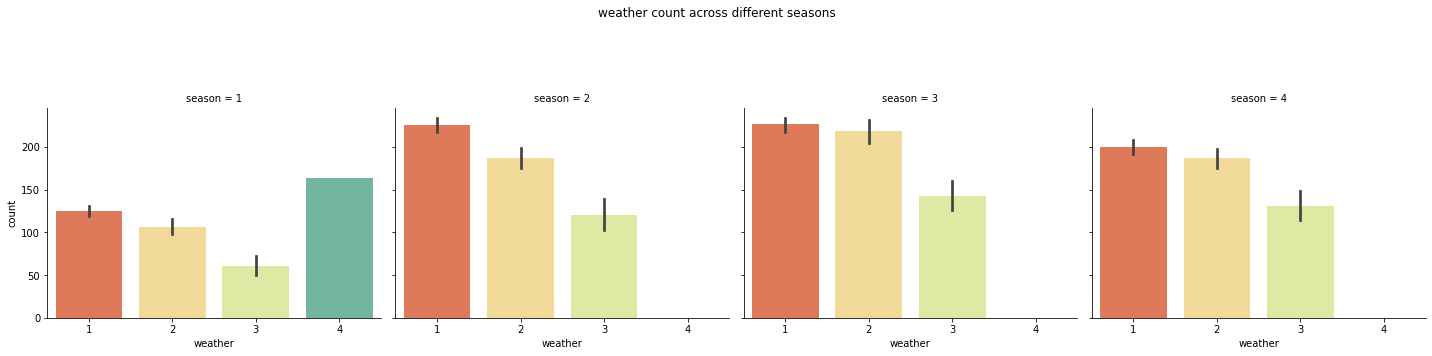

In [27]:
# weather count across different seasons
g = sn.catplot(x='weather',y='count',col='season', kind="bar", palette="Spectral", data=train)
g.fig.subplots_adjust(top=0.7) # adjust the Figure
g.fig.suptitle("weather count across different seasons")


weather -
1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fo

Horrible weather like weather 4 mainly happened in Spring season which supports our previous assumption that weather conditions play a major role in leading less bike rental demand during spring season.


Text(0, 0.5, 'Count')

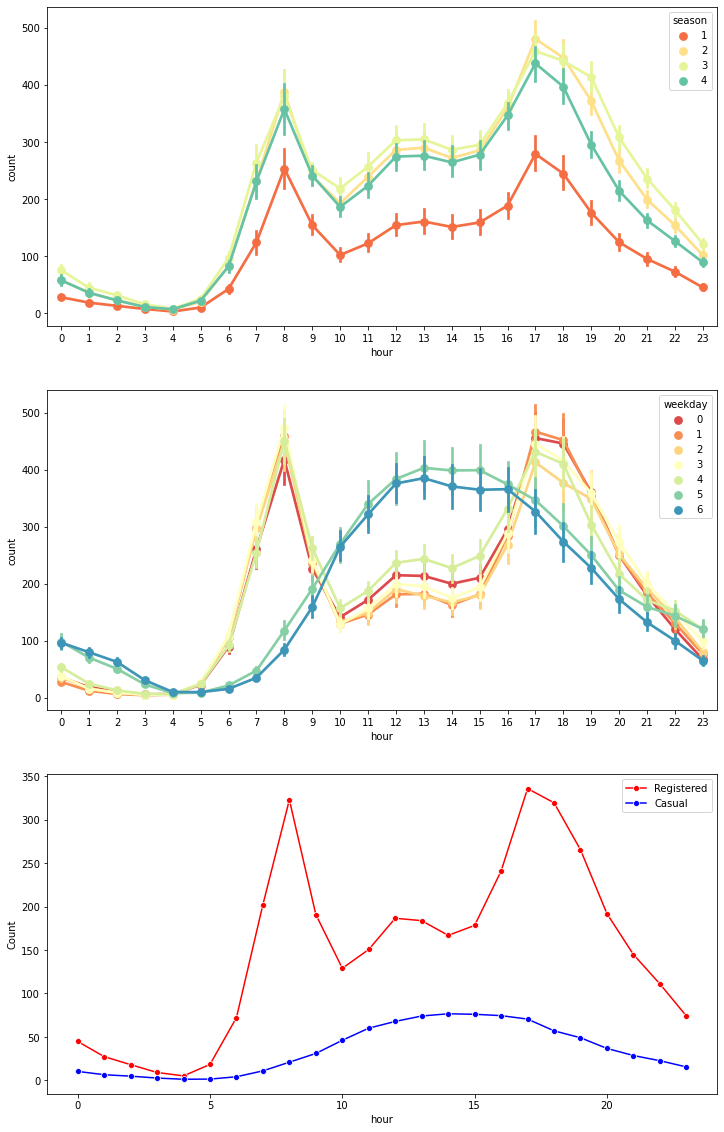

In [28]:
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3)
fig.set_size_inches(12,20)
sn.pointplot(x='hour',y='count',hue='season',join=True, data=train, palette="Spectral", ax=ax1)
sn.pointplot(x='hour',y='count',hue='weekday',join=True, data=train, palette="Spectral", ax=ax2)
sn.lineplot(x='hour', y='registered', data=train, color='red',label='Registered', marker='o', ax=ax3, ci=None)
sn.lineplot(x='hour', y='casual', data=train, color='blue', label='Casual', marker='o', ax=ax3, ci=None)
ax3.set_ylabel('Count')



- It is observed that many people, regardless of their registration status, tend to rent bicycles between 10AM and 4PM. This trend is likely due to the fact that people are more likely to use bicycles for leisure activities during this time of the day. 

- Furthermore, it is also found that most un-registered users tend to rent bicycles around 10am-3pm on weekends. This could be because casual users may use other forms of transportation to go to work/school during the weekdays and only rent bicycles during weekends for recreational activities. 

- On weekdays, the peak rental count around 7AM-8AM and 5PM-6PM is primarily contributed by registered users. As previously mentioned, this can be attributed to regular school and office commuters who rely on bicycles as their primary mode of transportation during these times.

<AxesSubplot:ylabel='Density'>

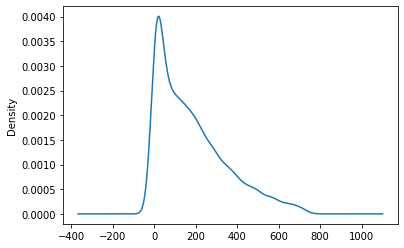

In [29]:
# Kernel Density Estimation plot 
train['count'].plot(kind='kde')

<AxesSubplot:ylabel='Density'>

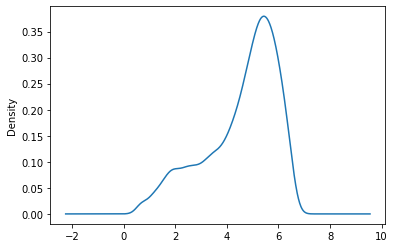

In [30]:
# log trnasformation for skewed count data
import math
train['count_log']=np.log1p(train['count'])
train['count_log'].plot(kind='kde')

# Model

## Metrics

In [31]:
# metrics
def rmsle(y_real, y_pre):    
    log1 = np.log1p(y_real)
    log2 = np.log1p(y_pre)    
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

## Split Dataset

In [32]:
train.columns

Index(['index', 'datetime', 'season', 'holiday', 'workingday', 'weather',
       'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered',
       'count', 'year', 'month', 'day', 'hour', 'week', 'weekday',
       'count_log'],
      dtype='object')

In [33]:
test.columns

Index(['index', 'datetime', 'season', 'holiday', 'workingday', 'weather',
       'temp', 'atemp', 'humidity', 'windspeed', 'year', 'month', 'day',
       'hour', 'week', 'weekday'],
      dtype='object')

In [34]:
drop_columns = ['count', 'count_log', 'casual', 'registered', 'index', 'datetime']
X_train = train.drop(drop_columns, axis = 1).values
X_test = test.drop(['index', 'datetime'], axis = 1).values

yLog = train['count_log'].values
x_date = test['datetime'].values

In [35]:
X_train.shape

(10739, 14)

In [36]:
X_test.shape

(6493, 14)

In [37]:
rf_columns = [
    'weather', 'temp', 'windspeed',
    'workingday', 'season', 'holiday',
    'hour', 'weekday', 'week',
]
gb_columns =[
    'weather', 'temp', 'humidity', 'windspeed',
    'workingday', 'season', 'holiday',
    'hour', 'weekday', 'year', 
]

In [38]:
rf_x_train=train[rf_columns].values
rf_x_test=test[rf_columns].values

gb_x_train=train[gb_columns].values
gb_x_test=test[gb_columns].values

y_casual=train['casual'].apply(lambda x: np.log1p(x)).values
y_registered=train['registered'].apply(lambda x: np.log1p(x)).values
y=train['count'].apply(lambda x: np.log1p(x)).values

X_date=test['datetime'].values

In [39]:
# Split training dataset
from sklearn.model_selection import train_test_split
drop_columns = ['count', 'count_log', 'casual', 'registered', 'index', 'datetime']
X_train = train.drop(drop_columns, axis = 1).values
xd_train,xd_test,yd_train,yd_test = train_test_split(X_train,y,random_state=0)

## XGBoost

In [40]:
xgb_model = xgb.XGBRegressor()
def XGB_model():
    xgb_parameters = {'random_state': [42], 
                  'n_estimators': [300, 370, 400], 
                  'max_depth': [4, 5], 
                  'learning_rate': [0.1]}
    rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better = False)

    gs = GridSearchCV(estimator = xgb_model, param_grid = xgb_parameters, scoring = rmsle_scorer, cv = 5)
    gs.fit(xd_train, yd_train)
    print('Best params for XGBoost model are: ', gs.best_params_)
    #
    test_pred = gs.predict(xd_test)
    # calculate RMSLE
    score = rmsle(yd_test,test_pred)
    return score

## Random Forest

In [41]:
from sklearn.ensemble import RandomForestRegressor
def RandomForest_model():
    params = {'n_estimators': 1000, 
              'max_depth': 15, 
              'random_state': 0, 
              'min_samples_split' : 2, 
              'n_jobs': -1}

    rfr = RandomForestRegressor(**params)
    rfr.fit(xd_train, yd_train)
    test_pred = rfr.predict(xd_test)
    # calculate RMSLE
    score = rmsle(yd_test,test_pred)
    return score

## GradientBoostTree

In [42]:
from sklearn.ensemble import GradientBoostingRegressor
def GradientBoosting_model():
    gbr = GradientBoostingRegressor(n_estimators = 1000, 
                                    max_depth = 5, 
                                    random_state = 0)
    gbr.fit(xd_train,yd_train)
    test_pred = gbr.predict(xd_test)
    score = rmsle(yd_test,test_pred)
    return score

In [43]:
print("RMSLE Score for different models")
print("XGBoost:      ",XGB_model())
print("RandomForest: ",RandomForest_model())
print("GradientBoost: ",GradientBoosting_model())

RMSLE Score for different models
Best params for XGBoost model are:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 400, 'random_state': 42}
XGBoost:       0.07957196959997952
RandomForest:  0.08143885821515123
GradientBoost:  0.08106742308844261


## Model Prediction

The count pattern between casual and registered users are really different so it's better to use two models to predict them seperately and then sum up the prediction.

In [44]:
# XGBoost
xgb_params = {'random_state': 42, 
              'n_estimators': 200, 
              'max_depth': 5, 
              'learning_rate': 0.1}

XGB1 = xgb.XGBRegressor(**xgb_params)
XGB1.fit(gb_x_train,y_casual)
print("model score for prediting casual count:",XGB1.score(gb_x_train,y_casual))

XGB2 = xgb.XGBRegressor(**xgb_params)
XGB2.fit(gb_x_train,y_registered)
print("model score for prediting registered count:",XGB2.score(gb_x_train,y_registered))

XGB3 = xgb.XGBRegressor(**xgb_params)
XGB3.fit(gb_x_train,y)
print("model score for prediting count:",XGB3.score(gb_x_train,y))

model score for prediting casual count: 0.9226294838216818
model score for prediting registered count: 0.970395797544881
model score for prediting count: 0.9704984642511707


<Figure size 1080x864 with 0 Axes>

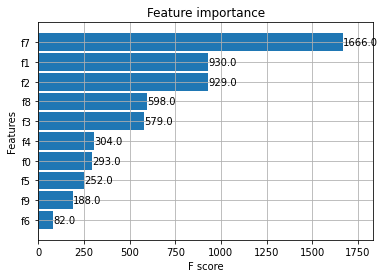

In [45]:
from xgboost import plot_importance, plot_tree
fig = plt.figure(figsize=(15,12))
fig = plot_importance(XGB3, height=0.9,max_num_features = 25)
plt.show()

In [46]:
# random forest
# params = {'n_estimators': 1000, 
#           'max_depth': 15, 
#           'random_state': 0, 
#           'min_samples_split' : 2, 
#           'n_jobs': -1}

# rfr = RandomForestRegressor(**params)
# rfr.fit(X_train, yLog)
# pred_rf = rfr.predict(X_test)

In [47]:
# gradient boosting
from sklearn.ensemble import GradientBoostingRegressor

gbr_params = {'n_estimators': 150, 
           'max_depth': 5, 
           'random_state': 0, 
           'min_samples_leaf' : 10, 
           'learning_rate': 0.1, 
           'subsample': 0.7, 
           'loss': 'ls'}

GBR1 = GradientBoostingRegressor(**gbr_params)
GBR1.fit(gb_x_train,y_casual)
print("model score for prediting casual count:",GBR1.score(gb_x_train,y_casual))

GBR2 = GradientBoostingRegressor(**gbr_params)
GBR2.fit(gb_x_train,y_registered)
print("model score for prediting registered count:",GBR2.score(gb_x_train,y_registered))

GBR3 = GradientBoostingRegressor(**gbr_params)
GBR3.fit(gb_x_train,y)
print("model score for prediting count:",GBR3.score(gb_x_train,y))


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


model score for prediting casual count: 0.9182308992500625


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


model score for prediting registered count: 0.9681314008539198


/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:290: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  FutureWarning,


model score for prediting count: 0.9681860842764839


In [48]:
def prediction(x_test, models):
    prediction = []
    for model in models:
        pre = model.predict(x_test)
        pre = np.expm1(pre)
        prediction.append(pre)
    return sum(prediction)

pred_xgb = prediction(gb_x_test, models=[XGB1, XGB2])
pred_gbr = prediction(gb_x_test, models=[GBR1, GBR2])


In [49]:
prediction = (0.6 * pred_xgb) + (0.4 * pred_gbr)

In [50]:
submit = pd.DataFrame({'datetime':x_date,'count':prediction})
submit.to_csv('/kaggle/working/submisssion.csv',index=False)